In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/asl_alphabet

/content/drive/MyDrive/asl_alphabet


In [3]:
train_dir = 'asl_alphabet_train'
val_dir = 'asl_alphabet_val'
IMG_SIZE = 256,256

In [4]:
!ls

asl_alphabet_test	asl_alphabet_val  rebg.ipynb
asl_alphabet_train	model.h5	  test.ipynb
asl_alphabet_train.zip	model.ipynb	  Untitled0.ipynb


In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import glob
from keras.layers import *

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(   
    directory=train_dir,
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    seed=40,
    batch_size=256
)

val_data = tf.keras.preprocessing.image_dataset_from_directory( 
    directory=val_dir,
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    seed=40,
    batch_size=256
)

Found 5800 files belonging to 29 classes.
Found 1467 files belonging to 29 classes.


In [9]:
input_shape = (256, 256, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Tạo layer đầu vào
inputs = Input(shape=input_shape, name="input_layer")

# Thêm vào mô hình tuần tự tăng cường dữ liệu dưới dạng layer
# x = data_augmentation(inputs)

# Cung cấp đầu vào cho base_model (sau khi tăng cường) và không huấn luyện nó 
x = base_model(inputs, training=False)

# Gộp các đặc trưng đầu ra của base model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

# x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dense(256)(x)
x = Dropout(rate=.4)(x)  

# Đặt dense layer làm đầu ra
outputs = Dense(29, activation="softmax", name="output_layer")(x)

# Tạo mô hình với đầu vào và đầu ra
model = keras.Model(inputs, outputs)
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 29)                7453   

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.005),loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=8, verbose=1)
callbacks_list = [early_stopping]

In [12]:
model_hist = model.fit(train_data,validation_data = val_data, epochs = 60, callbacks=callbacks_list)

Epoch 1/60
23/23 [==============================] - 1184s 37s/step - loss: 1.3971 - accuracy: 0.6150 - val_loss: 0.3840 - val_accuracy: 0.8937
Epoch 2/60
23/23 [==============================] - 29s 1s/step - loss: 0.2468 - accuracy: 0.9250 - val_loss: 0.1543 - val_accuracy: 0.9591
Epoch 3/60
23/23 [==============================] - 30s 1s/step - loss: 0.1460 - accuracy: 0.9547 - val_loss: 0.1492 - val_accuracy: 0.9489
Epoch 4/60
23/23 [==============================] - 29s 1s/step - loss: 0.0914 - accuracy: 0.9729 - val_loss: 0.0778 - val_accuracy: 0.9761
Epoch 5/60
23/23 [==============================] - 29s 1s/step - loss: 0.0652 - accuracy: 0.9826 - val_loss: 0.0581 - val_accuracy: 0.9843
Epoch 6/60
23/23 [==============================] - 28s 1s/step - loss: 0.0507 - accuracy: 0.9879 - val_loss: 0.0605 - val_accuracy: 0.9836
Epoch 7/60
23/23 [==============================] - 29s 1s/step - loss: 0.0401 - accuracy: 0.9903 - val_loss: 0.0530 - val_accuracy: 0.9870
Epoch 8/60
23/23 

In [13]:
model.save('model.h5')

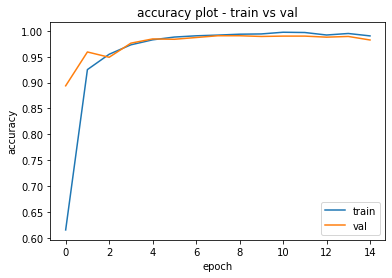

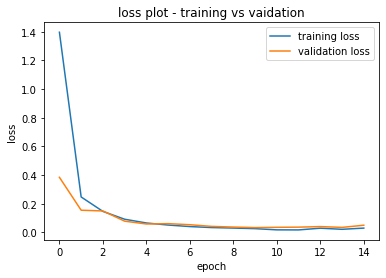

In [14]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['train', 'val'], loc='lower right')
plt.title('accuracy plot - train vs val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()